# Speech Accent Classifier MVP: American vs. Non-American Accents

**Problem Statement**: Using a dataset of 330 sets of [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) coefficients generated from .wav audio files of humans speaking, predict if the accent is american or from another country. This is a binary classification problem.

**Use Case** - Call centers/technical support centers could use this model to automatically screen callers for their accent and match them with an agent (human or not) that speaks in an accent/language they can easily understand.

**Evaluation Metrics** - It is equally important that the model recognizes American or non-American accents. Therefore accuracy is a good measure of model performance, as well as the ROC AOC.

**Future Goal** - Generate additional data for the non-US (ES, FR, GE, IT, UK) accents and create a model that can predict which accent among 6 countries of origin.

_Fokoue, E. (2020). UCI Machine Learning Repository, Irvine, CA: University of California, School of Information and Computer Science._

---

## 1. Setup

Import necessary libraries.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [165]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from utilities import fit_and_cross_validate_score_model, plot_distribution_pair, fit_and_cross_validate_score_roc_auc

Connect to PostgreSQL database located on Amazon EC2 instance.

In [5]:
cnx = create_engine('postgresql://ubuntu@13.59.21.81:5432/speech_accent_classifier')

---
## 2. Data Cleaning

Load data from PostreSQL database.

In [6]:
df_accent = pd.read_sql_query('''SELECT * FROM accent_mfcc''', cnx)
df_accent.head()

,language,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,ES,7.071476,-6.512900,7.650800,11.150783,-7.657312,12.484021,-11.709772,3.426596,1.462715,-2.812753,0.866538,-5.244274
1,ES,10.982967,-5.157445,3.952060,11.529381,-7.638047,12.136098,-12.036247,3.491943,0.595441,-4.508811,2.332147,-6.221857
2,ES,7.827108,-5.477472,7.816257,9.187592,-7.172511,11.715299,-13.847214,4.574075,-1.687559,-7.204041,-0.011847,-6.463144
3,ES,6.744083,-5.688920,6.546789,9.000183,-6.924963,11.710766,-12.374388,6.169879,-0.544747,-6.019237,1.358559,-6.356441
4,ES,5.836843,-5.326557,7.472265,8.847440,-6.773244,12.677218,-12.315061,4.416344,0.193500,-3.644812,2.151239,-6.816310


In [7]:
df_accent.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000,329.000000
mean,5.645227,-4.270814,2.635319,7.200207,-5.648733,9.810236,-9.408053,5.117328,-1.229432,-2.362288,2.430833,-3.980415
std,5.105302,3.514350,3.635323,4.310095,4.596180,3.624654,2.484117,2.650608,3.634849,5.042034,3.478467,2.985879
min,-6.067831,-14.972962,-6.186583,-8.844231,-15.656596,-3.528964,-15.365665,-2.873862,-15.510974,-11.429178,-13.664104,-13.724103
25%,2.065603,-6.515764,0.137042,4.700874,-8.417684,8.643563,-11.120860,3.482167,-1.749082,-5.083522,1.197789,-5.941409
50%,4.954206,-4.252512,2.029268,7.804680,-6.786670,10.379330,-9.710399,4.843103,-0.389970,-3.323147,3.169703,-4.374334
75%,9.793648,-1.560250,4.178026,10.129165,-4.463308,11.784360,-7.989370,6.588931,0.779993,-1.506037,4.673452,-2.191658
max,17.749851,3.570765,17.066487,16.178942,7.912809,21.445837,-0.424033,13.846083,4.789989,16.326455,9.166066,5.259430


In [8]:
df_accent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   language  329 non-null    object 
 1   x1        329 non-null    float64
 2   x2        329 non-null    float64
 3   x3        329 non-null    float64
 4   x4        329 non-null    float64
 5   x5        329 non-null    float64
 6   x6        329 non-null    float64
 7   x7        329 non-null    float64
 8   x8        329 non-null    float64
 9   x9        329 non-null    float64
 10  x10       329 non-null    float64
 11  x11       329 non-null    float64
 12  x12       329 non-null    float64
dtypes: float64(12), object(1)
memory usage: 33.5+ KB


Data quality is actually really good. Distributions seem reasonable so far, and no null values.

For the MVP model, create a column that is boolean for US or not US.

In [9]:
df_accent['isUS'] = [True if l == 'US' else False for l in df_accent['language']]

## 3. Exploratory Data Analysis (EDA)

### 3.1 Train/Test Split

Split data into train/val and test sets.

In [10]:
X = df_accent.drop(['language', 'isUS'], axis=1)
y = df_accent['isUS']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Merge training features and labels back together for EDA.

In [11]:
df_train = X_train_val.copy()
df_train['isUS'] = y_train_val

While there are some apparent outliers, it seems that since the MFCC features are extracted directly from the audio files, it seems like all data files could be significant. Requires more domain knowledge to interpret.

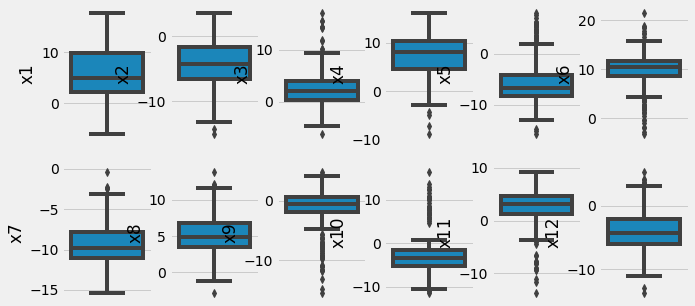

In [25]:
f, axes = plt.subplots(2, 6)
f.set_size_inches(10, 5)
cols = np.array(X_train_val.columns).reshape(2, 6)
for i in range(2):
    for j in range(6):       
        sns.boxplot(df_train[cols[i, j]], orient='v', ax=axes[i, j])

### 3.2 Checking Class Balance

There is **no class imbalance** when considering American vs. non-American accents.

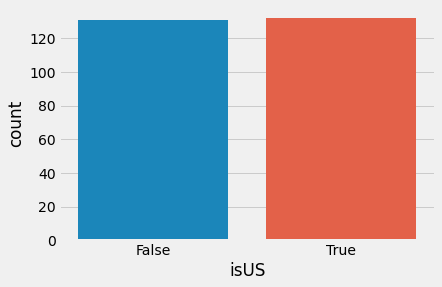

In [39]:
sns.countplot(x='isUS', data=df_train)

### 3.3 Pair Plot
Looking for separability in features. While there is a lot of overlap, there do appear to be some slight separability in the effect of each feature on its predicited label. Something particularly interesting are the several bimodal distributions.

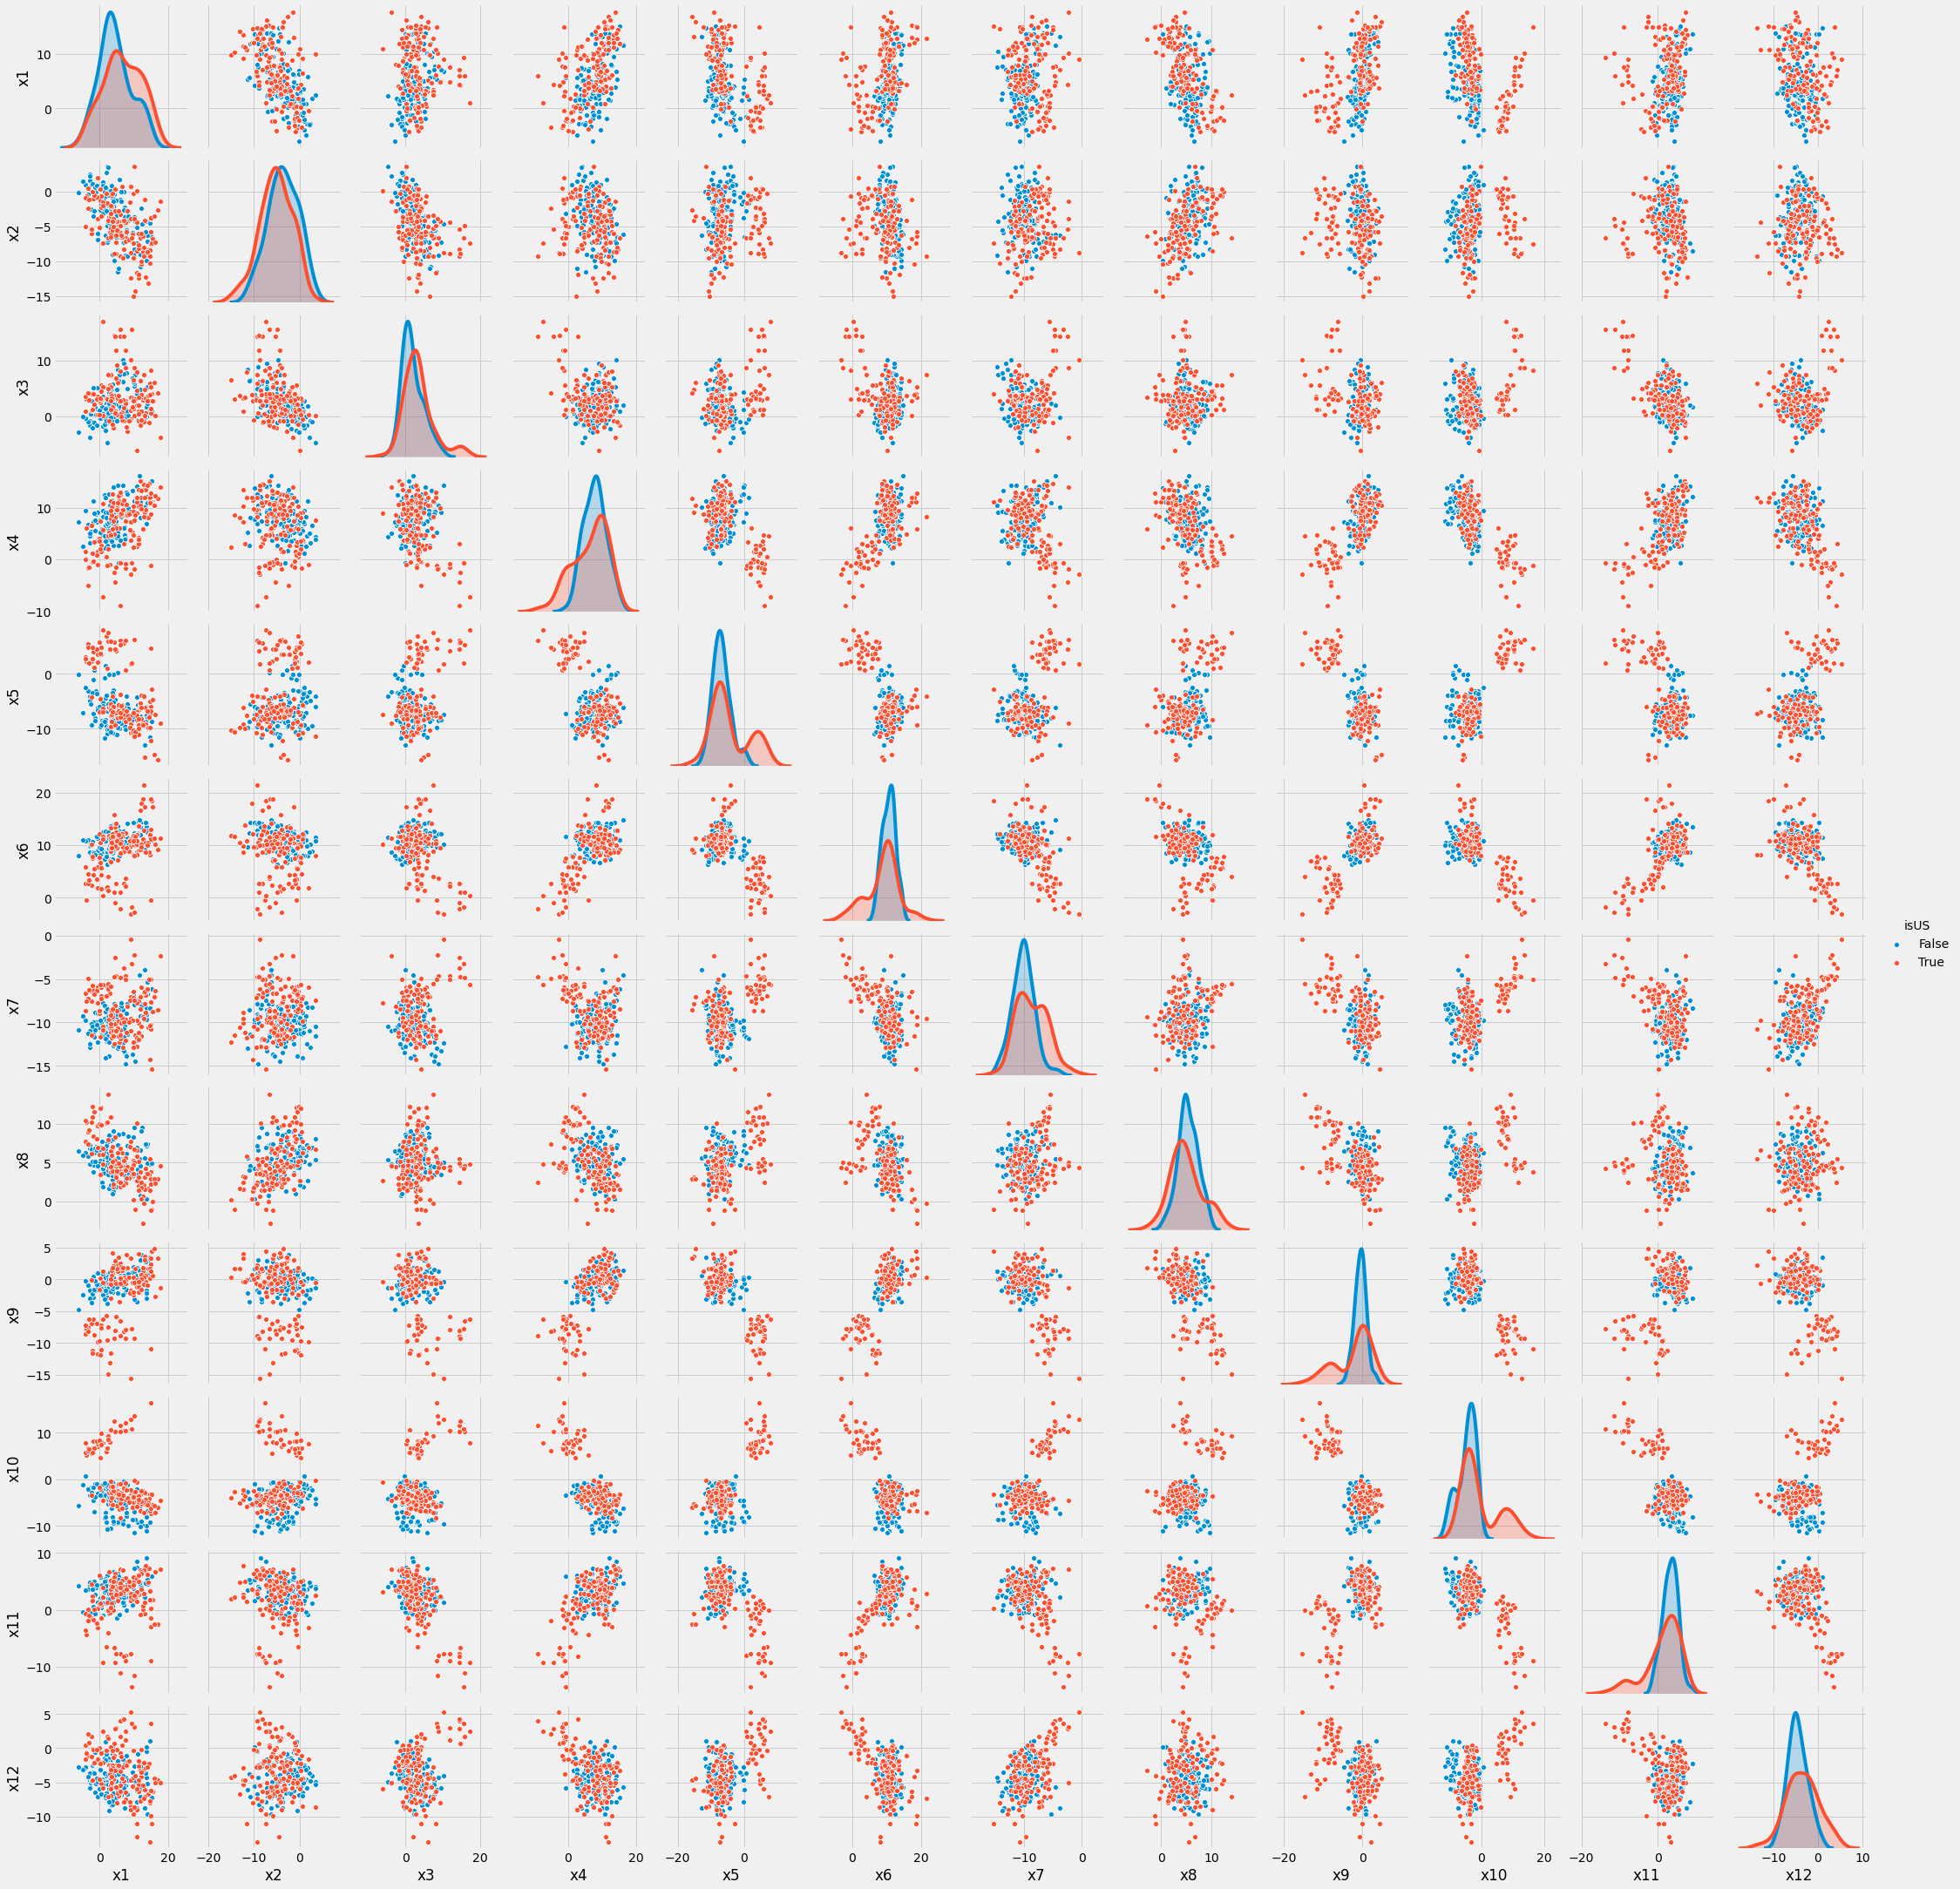

In [40]:
sns.pairplot(df_train, hue='isUS');

### 3.4 Correlation Matrix

Plotting a heat map of the correlation matrix. 

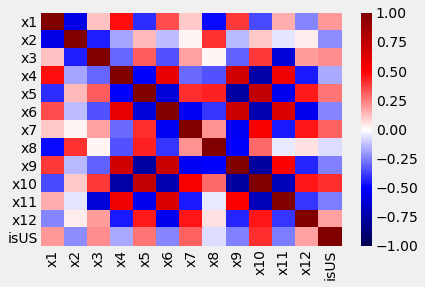

In [44]:
sns.heatmap(df_train.corr(), cmap='seismic', vmin=-1, vmax=1)

## 4. Baseline Models

Fit baseline models for a variety of classification algorithms (including a dummy model). This will serve as a basis for feature engineering and tuning.

### 3.1 Train/Val Spliit
Split data into training and validation set.

In [48]:
X_train_val = df_train.drop(['isUS'], axis=1)
y_train_val = df_train['isUS']

In [153]:
baseline_models = [
    ('Dummy', DummyClassifier(strategy="most_frequent")),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=0)),
    #('SVM', SVC())
    #('Decision Tree', DecisionTreeClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression(random_state=0)),
    # XGBoost
]

In [166]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.966014,0.905246
2,Random Forest,1.000000,0.884762
3,Naive Bayes,0.741520,0.719805
4,Logistic Regression,0.872634,0.824994


## 5. Feature Engineering

Trying out unique features that will boost the performance of the model.

### 5.1 Removing multicolinearities

As a quick, conservative way of removing multicolinearities, if any features have an absolute correlation > 0.7, I'll remove them and see how that affects overfitting.

In [208]:
df_feat_eng = df_train.copy()

Features with > 0.7 absolute correlation.
- `x9` and `x6`
- `x9` and `x4`
- `x9` and `x5`
- `x9` and `x10`
- `x10` and `x5`
- `x10` and `x4`
- `x10` and `x6`
- `x10` and `x11`

Out of those, `x10` has the strongest correlation with `isUS`, so I'll try removing `x4`, `x5`, `x6`, `x9`.

In [186]:
df_feat_eng_x4 = df_feat_eng.drop('x4', axis=1)

In [188]:
X_train_val_x4 = df_feat_eng_x4.drop(['isUS'], axis=1)
y_train_val_x4 = df_feat_eng_x4['isUS']

In [190]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x4, y_train_val_x4))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.960981,0.902820
2,Random Forest,1.000000,0.905294
3,Naive Bayes,0.748552,0.726600
4,Logistic Regression,0.868661,0.850825


In [191]:
df_feat_eng_x5 = df_feat_eng.drop('x5', axis=1)

In [192]:
X_train_val_x5 = df_feat_eng_x5.drop(['isUS'], axis=1)
y_train_val_x5 = df_feat_eng_x5['isUS']

In [193]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x5, y_train_val_x5))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.962826,0.887590
2,Random Forest,1.000000,0.889844
3,Naive Bayes,0.759885,0.734864
4,Logistic Regression,0.867434,0.817097


In [194]:
df_feat_eng_x6 = df_feat_eng.drop('x6', axis=1)

In [195]:
X_train_val_x6 = df_feat_eng_x6.drop(['isUS'], axis=1)
y_train_val_x6 = df_feat_eng_x6['isUS']

In [196]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x6, y_train_val_x6))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.953868,0.877722
2,Random Forest,1.000000,0.886135
3,Naive Bayes,0.750376,0.736175
4,Logistic Regression,0.866898,0.828357


In [197]:
df_feat_eng_x9 = df_feat_eng.drop('x9', axis=1)

In [198]:
X_train_val_x9 = df_feat_eng_x9.drop(['isUS'], axis=1)
y_train_val_x9 = df_feat_eng_x9['isUS']

In [199]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x9, y_train_val_x9))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.966520,0.909718
2,Random Forest,1.000000,0.863254
3,Naive Bayes,0.724635,0.704219
4,Logistic Regression,0.867748,0.847078


It seems like  `x4` is the only possibly-multicolinear feature that reduces overfitting and doesn't negatively impact the scores of all models. For this round of feature engineering I'll only remove that feature.

In [209]:
df_feat_eng.drop('x4', axis=1, inplace=True)

### 5.2 Bimodal Distribution

Some of the features have bimodal distributions on the positive class. What would happen if I added a categorical feature that gave weight to points that are in that second "hump".

Starting with `x10`, plotting the distribution more up close to see where that separation occurs.

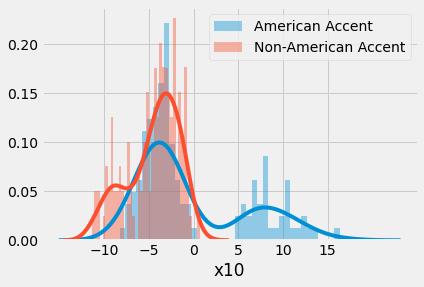

In [202]:
plot_distribution_pair(
    d1=df_train[df_train['isUS']]['x10'],
    d2=df_train[df_train['isUS'] == False]['x10'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-10,
    tick_max=20,
    tick_interval=5,
    n_bins=40
)

This indicates that a good categorical feature might indicate if `x10` is greater than `2.5`.

In [210]:
df_feat_eng_x10_range = df_feat_eng.copy()
df_feat_eng_x10_range['x10_range'] = df_feat_eng['x10'] > 2.5

Checking baseline models again.

In [211]:
X_train_val_x10_range = df_feat_eng_x10_range.drop('isUS', axis=1)
y_train_val_x10_range = df_feat_eng_x10_range['isUS']

In [212]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x10_range, y_train_val_x10_range))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.961391,0.899163
2,Random Forest,1.000000,0.897812
3,Naive Bayes,0.746705,0.725450
4,Logistic Regression,0.872204,0.835194


No huge improvement, but some potential here. Repeating this for all of the other features with bimodal disttributions (when `isUS = True`).

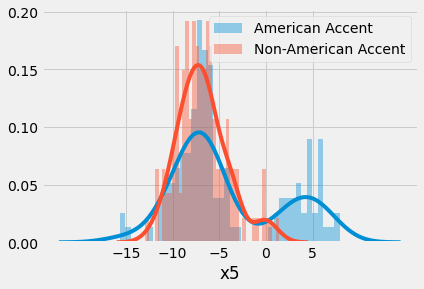

In [107]:
plot_distribution_pair(
    d1=df_train[df_train['isUS']]['x5'],
    d2=df_train[df_train['isUS'] == False]['x5'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-15,
    tick_max=10,
    tick_interval=5,
    n_bins=40
)

In [213]:
df_feat_eng_x5_range = df_feat_eng.copy()
df_feat_eng_x5_range['x5_range'] = df_feat_eng['x5'] > 2

In [214]:
X_train_val_x5_range = df_feat_eng_x5_range.drop('isUS', axis=1)
y_train_val_x5_range = df_feat_eng_x5_range['isUS']

In [215]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x5_range, y_train_val_x5_range))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.961663,0.912450
2,Random Forest,1.000000,0.896506
3,Naive Bayes,0.745292,0.722508
4,Logistic Regression,0.871859,0.831796


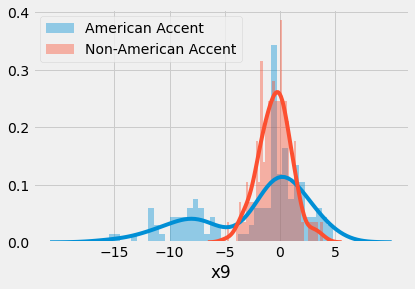

In [108]:
plot_distribution_pair(
    d1=df_train[df_train['isUS']]['x9'],
    d2=df_train[df_train['isUS'] == False]['x9'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-15,
    tick_max=10,
    tick_interval=5,
    n_bins=40
)

In [216]:
df_feat_eng_x9_range = df_feat_eng.copy()
df_feat_eng_x9_range['x9_range'] = df_feat_eng['x9'] < -5

In [217]:
X_train_val_x9_range = df_feat_eng_x9_range.drop('isUS', axis=1)
y_train_val_x9_range = df_feat_eng_x9_range['isUS']

In [218]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val_x9_range, y_train_val_x9_range))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.964454,0.882807
2,Random Forest,1.000000,0.890164
3,Naive Bayes,0.747995,0.730283
4,Logistic Regression,0.870678,0.837086


Adding the 3 features separately above all show some improvement across the models. What happens if we add all 3 "bimodal" features.

In [219]:
df_feat_eng_all_range = df_feat_eng.copy()
df_feat_eng_all_range['x9_range'] = df_feat_eng['x9'] < -5
df_feat_eng_all_range['x5_range'] = df_feat_eng['x5'] > 2
df_feat_eng_all_range['x10_range'] = df_feat_eng['x10'] > 2.5

Check for any possible multicolinearities using a correlation matrix.

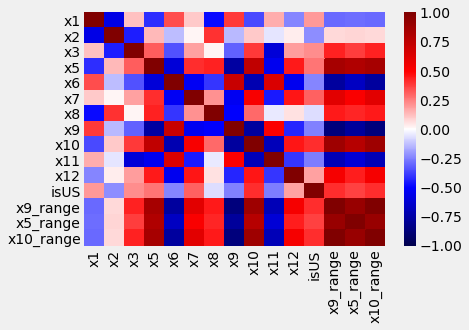

In [221]:
sns.heatmap(df_feat_eng_all_range.corr(), cmap='seismic', vmin=-1, vmax=1)

The three features I want to add have possible multicolinearity issues. The `x5` feature seems like the best choice based on its contribution to the model.

In [223]:
df_feat_eng['x5_range'] = df_feat_eng['x5'] > 2

### 5.3 Interaction Features TODO (?)

There might be some features that have more strength when multiplied together.

In [246]:
df_feat_eng_interact = df_feat_eng.copy()

In [247]:
df_feat_eng_interact['x1x9'] = df_feat_eng_interact['x1']*df_feat_eng_interact['x10']

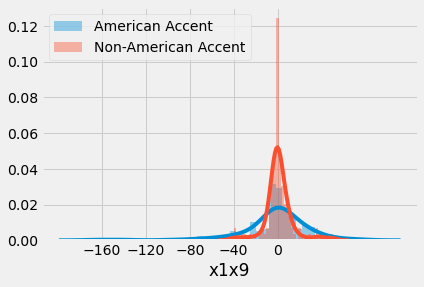

In [248]:
plot_distribution_pair(
    d1=df_feat_eng_interact[df_feat_eng_interact['isUS']]['x1x9'],
    d2=df_feat_eng_interact[df_feat_eng_interact['isUS'] == False]['x1x9'],
    d1_label='American Accent',
    d2_label='Non-American Accent',
    tick_min=-160,
    tick_max=40,
    tick_interval=40,
    n_bins=40
)

## 6. Model Tuning & Optimization

Check how the models are performing at this point.

In [249]:
X_train_val = df_feat_eng.drop(['isUS'], axis=1)
y_train_val = df_feat_eng['isUS']

In [251]:
metrics = []
for estimator in baseline_models:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Dummy,0.500000,0.500000
1,K-Nearest Neighbors,0.963140,0.902781
2,Random Forest,1.000000,0.881779
3,Naive Bayes,0.747468,0.732648
4,Logistic Regression,0.870293,0.843156


Naive Bayes seems liike a weak link. I'll work on optimizing KNN, Random Forest, and Logistic Regression.

### 6.1 K-Nearest Neighbors

Try a coarse hyperparameter tuning (on number of neighbors).

In [252]:
knn_models_1 = [
    ('KNN (k=5)', KNeighborsClassifier()),
    ('KNN (k=10)', KNeighborsClassifier(n_neighbors=10)),
    ('KNN (k=25)', KNeighborsClassifier(n_neighbors=25)),
    ('KNN (k=50)', KNeighborsClassifier(n_neighbors=50)),
    ('KNN (k=100)', KNeighborsClassifier(n_neighbors=100)),
]

In [254]:
metrics = []
for estimator in knn_models_1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN (k=5),0.965274,0.914351
1,KNN (k=10),0.952219,0.909084
2,KNN (k=25),0.905725,0.885638
3,KNN (k=50),0.838481,0.821364
4,KNN (k=100),0.768379,0.750132


Seems like the single digits works the best.

In [255]:
knn_models_2 = [(f'KNN (k={k + 1})', KNeighborsClassifier(n_neighbors=k + 1)) for k in range(10)]

In [256]:
metrics = []
for estimator in knn_models_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN (k=1),1.000000,0.817490
1,KNN (k=2),0.982403,0.886049
2,KNN (k=3),0.981171,0.906087
3,KNN (k=4),0.974833,0.906810
4,KNN (k=5),0.967812,0.905353
5,KNN (k=6),0.962174,0.917723
6,KNN (k=7),0.957896,0.923262
7,KNN (k=8),0.953721,0.904512
8,KNN (k=9),0.949809,0.924918
9,KNN (k=10),0.950235,0.913711


Looks like `n_neighbors=9` (the baseline KNN) produces the best ROC AUC.

### 6.2 Random Forest

Do coarse tuning on number of estimators to use.

In [257]:
rf_models_1 = [
    ('Random Forest (n=10)', RandomForestClassifier(n_estimators=10, random_state=0)),
    ('Random Forest (n=100)', RandomForestClassifier(n_estimators=100, random_state=0)),
    ('Random Forest (n=1000)', RandomForestClassifier(n_estimators=1000, random_state=0))
]

In [259]:
metrics = []
for estimator in rf_models_1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (n=10),0.999892,0.865789
1,Random Forest (n=100),1.000000,0.889575
2,Random Forest (n=1000),1.000000,0.888086


Seems that the higher number of estimators, the better the scoring.

In [260]:
rf_models_2 = [
    ('Random Forest (n=10000)', RandomForestClassifier(n_estimators=10000, random_state=0))
]

In [262]:
metrics = []
for estimator in rf_models_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (n=10000),1.0,0.887989


Okay, not necessarily. What if I hover on the ~1000 order of magnitude.

In [265]:
rf_models_3 = [(f'Random Forest (e={e})', RandomForestClassifier(n_estimators=e, random_state=0)) for e in range(1000, 8000, 1000)]

In [266]:
metrics = []
for estimator in rf_models_3:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Random Forest (e=1000),1.0,0.889252
1,Random Forest (e=2000),1.0,0.899166
2,Random Forest (e=3000),1.0,0.893411
3,Random Forest (e=4000),1.0,0.896929
4,Random Forest (e=5000),1.0,0.885061
5,Random Forest (e=6000),1.0,0.903749
6,Random Forest (e=7000),1.0,0.897139


A random forest with `n_estimators = 6000` yields the highest ROC AUC and accuracy scores. 

### 6.3 Logistic Regression

Do a coarse tuning on `C` (inverse regularization strength).

In [267]:
logit_models_1 = [
    ('Logistic Regression (C=1)', LogisticRegression(random_state=0)),
    ('Logistic Regression (C=10)', LogisticRegression(C=10, random_state=0)),
    ('Logistic Regression (C=100)', LogisticRegression(C=100, random_state=0)),
    ('Logistic Regression (C=1000)', LogisticRegression(C=1000, random_state=0)),
]

In [270]:
metrics = []
for estimator in logit_models_1:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

/opt/anaconda3/envs/speechaccentclassifier/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,ROC AUC (Train),ROC AUC (Val)
0,Logistic Regression (C=1),0.870584,0.840377
1,Logistic Regression (C=10),0.870499,0.840772
2,Logistic Regression (C=100),0.872847,0.833400
3,Logistic Regression (C=1000),0.872212,0.846041


Using LogisticRegressionCV to see which `C` is selected based on accuracy.

In [271]:
lr = LogisticRegressionCV()
lr.fit(X_train_val, y_train_val)
lr.C_

array([0.00599484])

What do all of the scores look like at this value?

In [275]:
logit_models_2 = [
    ('Logistic Regression (C=0.006)', LogisticRegression(C=0.006, random_state=0)),
]
metrics = []
for estimator in logit_models_2:
    metrics.append(fit_and_cross_validate_score_roc_auc(estimator, X_train_val, y_train_val))
    
pd.DataFrame(metrics)

,Model,ROC AUC (Train),ROC AUC (Val)
0,Logistic Regression (C=0.006),0.861927,0.845713


### 6.4 Ensembling

In [285]:
ensemble = VotingClassifier(
    estimators=[
        ('knn', KNeighborsClassifier(n_neighbors=9)), 
        ('rf', RandomForestClassifier(n_estimators=6000)), 
        ('logit', LogisticRegression(C=0.006))
    ], 
    voting='soft'
)
scoring = fit_and_cross_validate_score_roc_auc(('Ensemble', ensemble), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,Ensemble,0.995914,0.905613


In [284]:
scoring = fit_and_cross_validate_score_roc_auc(('KNN', KNeighborsClassifier(n_neighbors=9)), X_train_val, y_train_val)
pd.DataFrame([scoring])

,Model,ROC AUC (Train),ROC AUC (Val)
0,KNN,0.950075,0.915061


In [ ]:
so far it seems like KNN is the best but is that what I want?

Adding engineered features to SQL - _do this as a final step to prepare data for deployment_

Doing this for 2 reasons:
1. The exercise of writing new columns in a SQL database.
2. Creating the optimal database to use in a deployed version of this model.